##### Nathan Lichtlé - Alain Riou - Robin San Roman
$%useful latex symbols$
$\newcommand{\(}{\left(}$
$\newcommand{\)}{\right)}$
$\newcommand{\GG}{\mathcal{G}}$
$\newcommand{\HH}{\mathcal{H}}$
$\newcommand{\JJ}{\mathbb{J}}$
$\newcommand{\NN}{\mathbb{N}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\argmin}[1]{\underset{#1}{\arg \min}\;}$
$\newcommand{\argmax}[1]{\underset{#1}{\arg \max}\;}$
$\newcommand{\df}[2]{\frac{\partial #1}{\partial #2}}$

# Image reconstruction in X-ray tomography

In [0]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse
import scipy.sparse.linalg as linalg
from scipy.io import loadmat

plt.rcParams['figure.figsize'] = (5,5)

## 1. X-ray tomography

X-ray tomography reconstructs dense volumes of objects from a set of projections measured at different angles. The measurements $y \in \RR^M$ and the sought absorption image $\bar{x} \in \RR^N$ obey the linear relation

$$\begin{equation}
y = H\bar{x} + w
\tag{1}
\end{equation}$$

where $w \in \RR^M$ is the measurement noise, that we assume i.i.d. Gaussian with variance $\sigma^2$. The tomography matrix $H \in \RR^{M \times N}$ is sparse and encodes the geometry of the measurements. Here, we will focus on the case when H models parallel projections of a 2-D object $\bar{x}$. Tomography measures are acquired at fixed and regularly sampled rotational positions between the sample and the detector so that $H_{m,n}$ models the intersection length between the $m$th light-ray and the $n$th pixel. If $N_\theta$ is the number of different angular positions of the detector in Fig. 1 and $L$ the linear size of the detector, the number of measurements $M = L \times N_\theta$. In practice, the angular positions are regularly distributed on $[0, \pi)$.

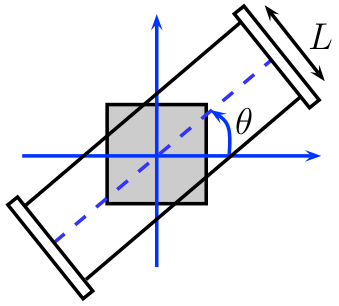
<center>Figure 1 – Considered tomographic acquisition model<center/>

Traditional reconstruction methods such as the Filtered Back-Projection require the linear system $(1)$ to be sufficiently determined for good results, i.e., $N_\theta \sim L$.

However, several applications could benefit from a smaller number of projections, either in order to reduce the total dose for medical applications, or to reduce the total acquisition time for in-situ experiments where the sample is evolving. Therefore, more sophisticated reconstruction approaches must be developed in order to overcome the under-determinacy of the problem and to make it robust to the presence of noise in the measurements.

1. Download the projection matrix $H$ and the image $\bar{x}$ available on the website. Use `loadmat` from `scipy.io` in Python to load the arrays, note that $H$ is stored as a sparse matrix.

In [0]:
!wget -nc --user ECP --password Optim http://www-syscom.univ-mlv.fr/~chouzeno/ECP/Slides/data.zip
!unzip -n data.zip

H = loadmat('data/H.mat')['H']
xbar = loadmat('data/x.mat')['x'].reshape(-1)
print('Done.')

File ‘data.zip’ already there; not retrieving.

Archive:  data.zip
Done.


2. Construct $y$, according to model $(1)$, using $\sigma = 1$.

In [0]:
M, N = H.shape
w = np.random.normal(0,1,M)
y = H @ xbar + w

3. Here, $N = 90 \times 90$ pixels and $M = 90 \times 180$ measurements. Display a 2D version of $\bar{x}$ and a 2D version of $y$, also known as sinogram. To do so, in Matlab, use the `reshape` function; in Python, use the `reshape` method with option `order=’F’`.

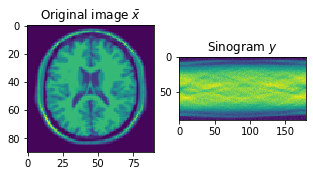

In [0]:
plt.subplot(1,2,1)
plt.imshow(xbar.reshape(90,90, order='F'))
plt.title('Original image $\\bar{x}$')
plt.subplot(1,2,2)
plt.imshow(y.reshape(90,180, order='F'))
plt.title('Sinogram $y$')
plt.show()

## 2. Optimization problem

An efficient strategy to address the reconstruction problem is to define $x$ as a minimizer of an appropriate cost function $f$. More specifically, we focus on the following penalized least-squares criterion:

$$\begin{equation}
\forall x \in \RR^N, \ f(x) = \frac{1}{2} \|Hx - y \|^2 + \lambda r(x)
\tag{2}
\end{equation}$$

where $r$ is a regularization function incorporating *a priori* assumptions to guarantee the robustness of the solution with respect to noise. In order to promote images formed by smooth regions separated by sharp edges, we set

$$\begin{equation}
\forall x \in \RR^N, \ r(x) = \sum_{n=1}^{2N} \psi \( [Gx]^{(n)} \)
\tag{3}
\end{equation}$$

where $G \in \RR^{2N \times N}$ is a sparse matrix such that $Gx \in \RR^{2N}$ is the concatenation of the horizontal and vertical gradients of the image, and $\psi$ is a potential function defined
as:

$$\begin{equation}
\psi(u) = \sqrt{1 + u^2/\delta^2}
\tag{4}
\end{equation}$$

with some parameter $\delta > 0$ aiming at guaranteeing the differentiability of $r$. In the following, we will set $(\lambda, \delta) = (0.13, 0.02)$.

1. Download the gradient operator $G$ available in the website.

In [0]:
!wget -nc --user ECP --password Optim http://www-syscom.univ-mlv.fr/~chouzeno/ECP/Slides/data.zip
!unzip -n data.zip

G = loadmat('data/G.mat')['G']
print('Done.')

File ‘data.zip’ already there; not retrieving.

Archive:  data.zip
Done.


2. Give the expression of the gradient $\nabla f$ at some point $x \in \RR^N$. Create a function which gives as an output the gradient of $f$ at some input vector $x$.

$$\df{}{x} \| Hx - y \|^2 = 2 H^\top \( Hx - y \)$$

Moreover, for $n \in \{1, \dots, 2N \}$:
$$\begin{aligned}
\df{\psi\( [Gx]^{(n)} \)}{x}
&= \df{\psi \([Gx]^{(n)} \)}{[Gx]^{(n)}} \df{[Gx]^{(n)}}{x} & \text{using the chain rule} \\
&= \df{\psi(u)}{u} \df{g_n^\top x}{x} & \text{where $g_n^\top$ denotes the $n$-th row of $G$} \\
&= \frac{[Gx]^{(n)}}{\delta^2 \psi \( [Gx]^{(n)} \)} g_n
\end{aligned}$$

Hence, by linearity, for $x \in \RR^N$:
$$\begin{aligned}
\nabla f(x)
&= H^\top \( Hx - y \) + \frac{\lambda}{\delta^2} \( \sum_{n=1}^{2N} \frac{[Gx]^{(n)}}{\psi \( [Gx]^{(n)} \) }
g_n \) \\
&= H^\top \( Hx - y \) + \frac{\lambda}{\delta^2} G^\top \widetilde{g}(x)
\end{aligned}$$
where $\widetilde{g}^{(n)}(x) = \frac{[Gx]^{(n)}}{\psi \( [Gx]^{(n)} \) }$ for all $n \in \{1, \dots, 2N \}$.

3. Show that a Lipschitz constant of $\nabla f$ is
$$L = \|H\|^2 + \(\lambda / \delta^2 \) \|G\|^2$$
Calculate it for the $(\lambda, \delta)$ values given above. Note that, in Matlab, one can use `normest` to evaluate the norm of a sparse matrix ; in Python, the function `scipy.sparse.linalg.svds` gives the singular values of a sparse matrix, the maximal singular value being the norm of the matrix.

Let $x, x' \in \RR^N$.

$$\begin{aligned}
\left\|H^\top \( Hx - y \) - H^\top \( Hx' - y \) \right\|
&= \left\| H^\top H (x - x') \right\| \\
&\leq \left\| H^\top H \right\| \left\| x - x' \right\| \\
&= \|H\|^2 \|x - x'\|
\end{aligned}$$

For $n \in \{1, \dots, 2N \}$:
$$\begin{aligned}
\left\| G^\top \widetilde{g}(x) - G^\top \widetilde{g}(x') \right\|
&= \left\| G^\top \( \widetilde{g}(x) - \widetilde{g}(x') \) \right\| \\
&= \TODO
\end{aligned}$$

Hence, by triangle inequality,
$$\begin{aligned}
\| \nabla f(x) - \nabla f(x') \|
&= \left\|H^\top \( Hx - y \) - H^\top \( Hx' - y \) + \frac{\lambda}{\delta^2} \(G^\top \widetilde{g}(x) - G^\top \widetilde{g}(x') \) \right\| \\
&\leq \left\|H^\top \( Hx - y \) - H^\top \( Hx' - y \) \right\| + \frac{\lambda}{\delta^2} \left\| G^\top \widetilde{g}(x) - G^\top \widetilde{g}(x') \right\| \\
&\leq \( \| H \|^2 + \frac{\lambda}{\delta^2} \| G \|^2 \) \|x - x' \|
\end{aligned}$$
i.e.
$$L = \|H\|^2 + \frac{\lambda}{\delta^2} \|G\|^2$$

In [0]:
lbda, delta = 0.13, 0.02

_, H_eigvals, _ = linalg.svds(H)
_, G_eigvals, _ = linalg.svds(G)

print('L =', H_eigvals[-1]**2 + lbda/(delta**2)*G_eigvals[-1]**2)

L = 18092.773276864806


## 3. Optimization algorithms

### 3.1 Gradient descent algorithm

1. Create $x_0 \in \RR^N$ a vector with all entries equal to 0. This will be our initialization for all tested algorithms.

In [0]:
x0 = np.zeros(N)

2. Implement a gradient descent algorithm to minimize $f$.

In [0]:
psi = lambda u: np.sqrt(1 + (u/delta)**2)

def f(x):
    norm = np.linalg.norm(H @ x - y)
    return norm**2 / 2.0 + lbda * np.sum(psi(G @ x))

def grad_f(x):
    Gx = G @ x
    grad = Gx / psi(Gx) @ G
    return H.T @ (H @ x - y) + lbda/(delta**2) * grad

def gradient_descent(x0, f, grad_f, n_iters=int(1e5), threshold=1e-2, lr=1e-4):
    fx_lst = [f(x0)]
    x = np.copy(x0)
    for k in range(n_iters):
        x -= lr * grad_f(x)
        fx_lst.append(f(x))
        norm_grad_f = np.linalg.norm(grad_f(x))
        stopping = norm_grad_f <= threshold
        if k % 100 == 0 or k == n_iters-1 or stopping:
            print("iter={}\tf(x)={:.3f}\t||∇f(x)||={:.3f}".format(k + 1, f(x), norm_grad_f))
        if stopping:
            print("stopping criterion reached, stopping now")
            break
    return x, fx_lst

In [0]:
x_sgd, fx_sgd = gradient_descent(x0, f, grad_f)

iter=1	f(x)=2152221.435	||∇f(x)||=247508.058
iter=101	f(x)=12904.741	||∇f(x)||=174.507
iter=201	f(x)=12803.143	||∇f(x)||=52.423
iter=301	f(x)=12789.326	||∇f(x)||=24.922
iter=401	f(x)=12785.741	||∇f(x)||=13.717
iter=501	f(x)=12784.578	||∇f(x)||=8.192
iter=601	f(x)=12784.140	||∇f(x)||=5.185
iter=701	f(x)=12783.959	||∇f(x)||=3.397
iter=801	f(x)=12783.880	||∇f(x)||=2.283
iter=901	f(x)=12783.843	||∇f(x)||=1.569
iter=1001	f(x)=12783.825	||∇f(x)||=1.100
iter=1101	f(x)=12783.817	||∇f(x)||=0.785
iter=1201	f(x)=12783.812	||∇f(x)||=0.569
iter=1301	f(x)=12783.810	||∇f(x)||=0.419
iter=1401	f(x)=12783.808	||∇f(x)||=0.311
iter=1501	f(x)=12783.808	||∇f(x)||=0.234
iter=1601	f(x)=12783.807	||∇f(x)||=0.178
iter=1701	f(x)=12783.807	||∇f(x)||=0.136
iter=1801	f(x)=12783.807	||∇f(x)||=0.105
iter=1901	f(x)=12783.807	||∇f(x)||=0.081
iter=2001	f(x)=12783.807	||∇f(x)||=0.063
iter=2101	f(x)=12783.807	||∇f(x)||=0.049
iter=2201	f(x)=12783.807	||∇f(x)||=0.039
iter=2301	f(x)=12783.807	||∇f(x)||=0.031
iter=2401	f(x)=1

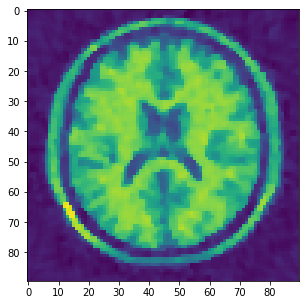

In [0]:
plt.imshow(x_sgd.reshape(90,90, order='F'))
plt.show()

### 3.2 MM quadratic algorithm

1. Construct, for all $x \in \RR^N$, a quadratic majorant function of $f$ at $x$. Create a function which gives, as an output, the curvature $A(x)$ of the majorant function at an input vector x.
Hint : in Matlab, use `spdiags` to create a sparse diagonal matrix; in Python, use `scipy.sparse.diags(d[:,0]).tocsc()` to create a sparse matrix from a diagonal vector $d \in \RR^{n \times 1}$ using the compressed sparse column format. In addition, in Python, use the class `LinearOperator` from `scipy.sparse.linalg` to create the curvature operator.

In [0]:
HtH = H.T @ H
coef = lbda / (delta ** 2)

def curvature(x, v):
    return HtH @ v + coef * (G.T @ (scipy.sparse.diags(1 / psi(G @ x)).tocsc() @ (G @ v)))

def curvature_t(x, v):
    return HtH.T @ v + coef * (G.T @ (scipy.sparse.diags(1 / psi(G @ x)).tocsc() @ (G @ v)))

def A(x):
    diag = scipy.sparse.diags(1 / psi(G @ x)).tocsc()

    def curvature(v):
        return HtH @ v + coef * (G.T @ (diag @ (G @ v)))
    def curvature_t(v):
        return HtH.T @ v + coef * (G.T @ (diag @ (G @ v)))

    return linalg.LinearOperator((N, N), matvec=curvature, rmatvec=curvature_t)

2. Deduce a MM quadratic algorithm to minimize $f$. Implement it.
Hint : in Matlab use `pcg` to invert the majorant matrix at each iteration ; in Python, use `bicg` from `scipy.sparse.linalg`.

In [0]:
def MM_quadratic(x0, f, grad_f, A, n_iters=int(1e5), threshold=1e-2, lr=0.3):
    fx_lst = [f(x0)]
    x = np.copy(x0)
    for k in range(n_iters):
        x -= lr * linalg.bicg(A(x), grad_f(x))[0]
        fx_lst.append(f(x))
        norm_grad_f = np.linalg.norm(grad_f(x))
        stopping = norm_grad_f <= threshold
        if k % 20 == 0 or k == n_iters-1 or stopping:
            print("iter={} \tf(x)={:.3f}\t||∇f(x)||={:.3f}".format(k + 1, f(x), norm_grad_f))
        if stopping:
            print("stopping criterion reached, stopping now")
            break
    return x, fx_lst

In [0]:
x_mmq, fx_mmq = MM_quadratic(x0, f, grad_f, A)

iter=1 	f(x)=3360138.255	||∇f(x)||=314513.627
iter=21 	f(x)=12792.170	||∇f(x)||=254.512
iter=41 	f(x)=12782.331	||∇f(x)||=9.127
iter=61 	f(x)=12781.873	||∇f(x)||=2.854
iter=81 	f(x)=12781.818	||∇f(x)||=1.091
iter=101 	f(x)=12781.809	||∇f(x)||=0.469
iter=121 	f(x)=12781.807	||∇f(x)||=0.217
iter=141 	f(x)=12781.807	||∇f(x)||=0.106
iter=161 	f(x)=12781.807	||∇f(x)||=0.053
iter=181 	f(x)=12781.807	||∇f(x)||=0.027
iter=201 	f(x)=12781.807	||∇f(x)||=0.014
iter=213 	f(x)=12781.807	||∇f(x)||=0.010
stopping criterion reached, stopping now


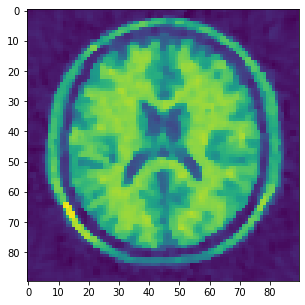

In [0]:
plt.imshow(x_mmq.reshape(90,90, order='F'))
plt.show()

### 3.3 3MG algorithm

The MM quadratic algorithm can be accelerated by using a subspace strategy. Here, we will focus on the so-called 3MG (MM Memory Gradient) approach which consists in defining the iterate $x_{k+1}$ as the minimizer of the quadratic majorant function at $x_k$ within a subspace spanned by the following directions:

$$\begin{equation}
\forall k \in \NN, \ D_k = \left[-\nabla f(x_k) \ | \ x_k - x_{k-1} \right]
\tag{5}
\end{equation}$$

(with the convention $D_0 = −\nabla f (x_0)$). Thus, an iterate of 3MG reads:

$$\begin{equation}
\forall k \in \NN, \ x_{k+1} = x_k + D_k u_k
\tag{6}
\end{equation}$$

with

$$\begin{equation}
\forall k \in \NN, \ u_k = - \( D_k^\top A(x_k) D_k \)^\dagger \(D_k^\top \nabla f (x_k) \)
\tag{7}
\end{equation}$$

where $A(x_k) \in \RR^{N \times N}$ is the curvature of the majorant matrix at $x_k$ and $\dagger$ denotes the pseudo-inverse operation.

1. Implement the 3MG algorithm.
Hint : use `pinv` in Matlab and `scipy.linalg.pinv` in Python to compute the pseudo-inverse. Given the size of the matrices, mind the order of matrix multiplications, e.g. when computing $D_k^\top H^\top H D_k$ do not compute $D_k^\top \( H^\top H \) D_k$ but $\(HD_k \)^\top \( HD_k \)$.

In [0]:
def MM_memory_gradient(x0, f, grad_f, n_iters=1000, threshold=1e-4, lr=1e-5):
    fx_lst = [f(x0)]
    x = np.copy(x0)
    D = - grad_f(x)[:,np.newaxis]
    xprev = np.copy(x)    
    for k in range(n_iters):
        grad = grad_f(x)
        HD = H @ D
        GD = G @ D
        DAD = HD.T @ HD + coef * GD.T @ scipy.sparse.diags(1 / psi(G @ x)).tocsc() @ GD
        if DAD.ndim == 0:
            DAD = DAD.reshape(1,1)
        u = -scipy.linalg.pinv(DAD) @ D.T @ grad
        x += D @ u
        fx_lst.append(f(x))
        stopping = np.linalg.norm(grad) < threshold
        if stopping or k % (n_iters // 20) == 0 or k == n_iters - 1:
            print("iter {}/{}:\tf(x) = {:.3f}\t||∇f(x)||={:.3f}".format(k + 1, n_iters, f(x), np.linalg.norm(grad)))
        if stopping:
            print("stopping criterion reached, stopping now")
            break        
        D = - np.vstack((grad, x - xprev)).T
        xprev = np.copy(x)
    return x, fx_lst

In [0]:
x_3mg, fx_3mg = MM_memory_gradient(x0, f, grad_f)

iter 1/1000:	f(x) = 264473.521	||∇f(x)||=449299.761
iter 51/1000:	f(x) = 13213.493	||∇f(x)||=758.518
iter 101/1000:	f(x) = 12848.501	||∇f(x)||=293.522
iter 151/1000:	f(x) = 12787.040	||∇f(x)||=51.030
iter 201/1000:	f(x) = 12782.108	||∇f(x)||=21.459
iter 251/1000:	f(x) = 12781.873	||∇f(x)||=8.137
iter 301/1000:	f(x) = 12781.810	||∇f(x)||=1.332
iter 351/1000:	f(x) = 12781.807	||∇f(x)||=0.312
iter 401/1000:	f(x) = 12781.807	||∇f(x)||=0.042
iter 451/1000:	f(x) = 12781.807	||∇f(x)||=0.009
iter 501/1000:	f(x) = 12781.807	||∇f(x)||=0.003
iter 551/1000:	f(x) = 12781.807	||∇f(x)||=0.001
iter 601/1000:	f(x) = 12781.807	||∇f(x)||=0.000
iter 608/1000:	f(x) = 12781.807	||∇f(x)||=0.000
stopping criterion reached, stopping now


### 3.4 Block-coordinate MM quadratic algorithm

*Arrays are indexed from index 0 in this notebook to be consistent with Python, whereas they are indexed from 1 in the original subject. Therefore, some formulas can be different.*

Another acceleration strategy consists in applying a block alternation technique.
The vector $x$ is divided into $J \geq 1$ blocks, with size $1 \leq N_j \leq N$. At each iteration $k \in \NN$, a block index $j \in \{0, \dots, J-1 \}$ is chosen, and the corresponding components
of $x$, denoted $x^{(j)}$, are updated, according to a MM quadratic rule. Here, we will assume that the blocks are selected in a cyclic manner, that is,

$$\begin{equation}
\forall k \in \NN, \ j = k \mod J
\tag{8}
\end{equation}$$

For a given block index $j$, the corresponding pixel indexes are updated in the image:

$$\begin{equation}
n \in \JJ_j = \left\{ j N_j, \dots, (j+1) N_j - 1\right\}
\tag{9}
\end{equation}$$

1. Create a function which gives, as an output, matrix $A_j(x) \in \RR^{N_j \times N_j}$ containing only the lines and rows of $A(x)$ with indexes $\JJ_j$.

In [0]:
def get_block(A, j, Nj):
    start, end = j*Nj, (j+1)*Nj
    return A[start:end,start:end]

2. Deduce an implementation of a block coordinate MM quadratic algorithm for minimizing $f$. Test it for $N_j = N/K$ with $K \in \{1, 2, 3, 5, 6, 9\}$.

In [0]:
def Aj(x, j, Nj):
    Gj, HtHj = get_block(G, j, Nj), get_block(HtH, j, Nj)
    diag = scipy.sparse.diags(1 / psi(Gj @ x)).tocsc()

    def curvature(v):
        return HtHj @ v + coef * (Gj.T @ (diag @ (Gj @ v)))
    def curvature_t(v):
        return HtHj.T @ v + coef * (Gj.T @ (diag @ (Gj @ v)))

    return linalg.LinearOperator((Nj, Nj), matvec=curvature, rmatvec=curvature_t)

def block_MM_quadratic(x0, f, grad_f, A, K, n_iters=1000, threshold=1e-2, lr=1e-4):
    Nj = N // K
    fx_lst = [f(x0)]
    x = np.copy(x0)
    for k in range(n_iters):
        j = k % K
        x[j*Nj:(j+1)*Nj] -= lr * linalg.bicg(A(x[j*Nj:(j+1)*Nj], j, Nj), grad_f(x)[j*Nj:(j+1)*Nj])[0]
        norm_grad_f = np.linalg.norm(grad_f(x))
        stopping = norm_grad_f <= threshold
        if k % 20 == 0 or k == n_iters-1 or stopping:
            print("iter={} \tf(x)={:.3f}\t||∇f(x)||={:.3f}".format(k + 1, f(x), norm_grad_f))
        if stopping:
            print("stopping criterion reached, stopping now")
            break
    return x

In [0]:
for K in [2, 3, 5, 6, 9]:
    print('K =', K)
    block_MM_quadratic(x0, f, grad_f, Aj, K)

K = 2
iter=1 	f(x)=6842888.970	||∇f(x)||=449445.450
iter=21 	f(x)=6821993.874	||∇f(x)||=448748.101
iter=41 	f(x)=6801169.041	||∇f(x)||=448051.965


### 3.5 Parallel MM quadratic algorithm

In order to benefit from the multicore structure of modern computer architecture, a parallel form of the MM quadratic algorithm is desirable. However, the quadratic majorizing function defined in Section 3.2 is not separable with respect to the entries of vector $x$ so that its minimization cannot be performed efficiently in a parallel manner. Here, we propose an alternative construction, that possesses a better potential for parallelization.

1. For every $x \in \RR^N$, let $B(x) \in \RR^{N \times N}$ be a diagonal matrix with elements

$$\begin{equation}
\forall i \in \{1, \dots, N \}, \ b^{(i)}(x) = \HH^\top \mathbf{1} + \lambda \GG^\top \( \frac{\phi \( Gx \)}{Gx} \)
\tag{10}
\end{equation}$$

with $\HH \in \RR^M$, $\GG \in \RR^{2N}$, and

$$\begin{equation}
\HH^{(m)} = | H^{(m,i)} | \sum_{p=1}^N | H^{(m,p)} | \qquad
\text{ and } \qquad
\GG^{(n)} = | G^{(n,i)} | \sum_{p=1}^N | G^{(n,p)} |
\tag{11}
\end{equation}$$

Prove that, for every $x \in \RR^N$, $A(x) \preceq B(x)$ where $A(·)$ was defined in Section 3.2. Hint : use Jensen’s inequality.

2. Deduce an implementation of a parallel MM quadratic algorithm or minimizing $f$.

In [0]:
def parallel_MM_quadratic():
    pass

### 3.6 Comparison of the methods

1. Create a function that computes the value of the criterion $f$ along the iterations of the algorithm.

In [0]:
# fx_sgd=...

2. We will consider that the convergence is reached when the following stopping criterion is fulfilled:

$$\begin{equation}
\| \nabla f (x_k) \| \leq \sqrt{N} \times 10^{-4}
\tag{12}
\end{equation}$$

What is the required time for each method to achieve this condition ? For each method, plot the decrease of $(f(x_k))_{k \in \NN}$ versus time until the stopping criterion is satisfied.

sgd
35498 iters


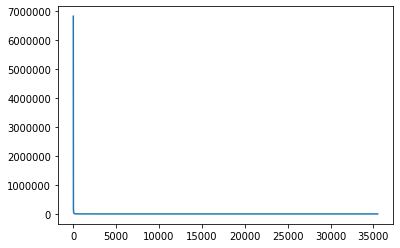

In [0]:
print("sgd")
print("{} iters".format(len(fx_sgd)))
plt.plot(fx_sgd) # decrease lr?

3. The Signal to Noise Ration (SNR) of a restored image $\widehat{x}$ is defined as

$$\begin{equation}
\text{SNR} = 10 \log_{10} \( \frac{\|\bar{x}\|^2}{\| \bar{x} - \widehat{x} \|^2} \)
\tag{13}
\end{equation}$$

Using the fastest method, search for parameters $(\lambda, \delta)$ that optimize the SNR.